In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/google_dist_code_1/google-research
#%cd /content/gdrive/My\ Drive/Accident_Anticipation/Anticipating-Accidents/dataset/videos/frames/

# pip install --upgrade scikit-image
!set -e
!set -x

# !virtualenv -p python3 .
# !source ./bin/activate

# !pip install tensorflow
!pip install tensorflow-graphics
# !pip install -r depth_from_video_in_the_wild/requirements.txt

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import logging
import os
import image_utils
import cv2

import re
import time
import glob
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image

import tensorflow as tf
from depth_from_video_in_the_wild import model

# https://github.com/google-research/google-research/tree/master/depth_from_video_in_the_wild

## Create correct crops in the google docs
## Output depth maps from optimal crops
## 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/google_dist_code_1/google-research
     |████████████████████████████████| 245kB 2.8MB/s 


In [0]:
def bounding_box_conversion(det, distances, input_shape):
  '''
  :::inputs:::
  list of distance map tuples (each batch has three crops of the distance maps)
  shape of input image
  det shape [10,100, 19, 6]: We want to transform to
  :::output:::
  reshape_det, which has shape[10,100,19, 7], where the first four dimensions are the reshaped coordinates, the SECOND-TO-last dimension is the crop that is used
  (with 0 --> middle crop, 1--> top crop, 2--> bottom crop. This pointer is found by seeing where the center coordinate of the bounding box is located)
  '''

  top_crop = 180  ## hard coded borders
  bottom_crop = 540

  det_reshape = np.zeros((10,100,19,7))

  for batch in range(10):
    for frame in range(100):
      for agent in range(19):
        det_slice = det[batch, frame, agent,:]
        if np.sum(det_slice != 0):
          x_mid = (det_slice[0]+det_slice[2])/2 ## calulating where the vertical midpoint of the bounding box lies, informing us of which crop we need to use

          # even if the input image size is different, for the horizontal axis we pad with zeros if it is not 1280, keeping the relative horizontal scaling factor the same
          final_height = 128
          final_width = 416
          
          det_reshape[batch,frame, agent, 4] = det[batch,frame, agent, 4] # copy over class
          det_reshape[batch,frame, agent, -1] = det[batch,frame, agent, -1] # copy over agent_id

          vertical_scaling = final_height/input_shape[0]
          horizontal_scaling = final_width/input_shape[1]

          ## Case 1: Fits into top region
          if x_mid < top_crop:
            det_reshape[batch,frame,agent,-2] = 1
            
            # no need to shift for top crop
            det_reshape[batch,frame, agent, 0] = np.round(det_slice[0]*vertical_scaling)
            det_reshape[batch,frame, agent, 1] = np.round(det_slice[1]*horizontal_scaling)
            det_reshape[batch,frame, agent, 3] = np.round(det_slice[3]*horizontal_scaling)

            if det_slice[2]<top_crop:
              det_reshape[batch,frame, agent, 2] = top_crop -1
            else:
              det_reshape[batch,frame, agent, 2] = np.round(det_slice[2]*vertical_scaling)

            ## calculating vertical resizing scaling fac

          ## Case 2: Fits into bottom region
          elif x_mid > bottom_crop:
            det_reshape[batch,frame,agent,-2] = 2

            ## vertical crop off-sets coordinates
            
            det_slice[2] = det_slice[2] - bottom_crop

            det_reshape[batch,frame, agent, 2] = np.round(det_slice[2]*vertical_scaling)
            det_reshape[batch,frame, agent, 1] = np.round(det_slice[1]*horizontal_scaling)
            det_reshape[batch,frame, agent, 3] = np.round(det_slice[3]*horizontal_scaling)

            if det_slice[0] < bottom_crop:
              det_reshape[batch,frame, agent, 0] = 0
            else:
              det_slice[0] = det_slice[0] - bottom_crop
              det_reshape[batch,frame, agent, 0] = np.round(det_slice[0]*vertical_scaling)

          ## Case 3: Fits into middle region
          else:
            det_reshape[batch,frame,agent,-2] = 0

            ## vertical crop off-sets coordinates
            det_slice[0] = det_slice[0] - top_crop
            det_slice[2] = det_slice[2] - top_crop

            det_reshape[batch,frame, agent, 1] = np.round(det_slice[1]*horizontal_scaling)
            det_reshape[batch,frame, agent, 3] = np.round(det_slice[3]*horizontal_scaling)

            if det_slice[0]<top_crop:
              det_reshape[batch,frame, agent, 2] = 0
            else:
              det_slice[0] = det_slice[0] - top_crop
              det_reshape[batch,frame, agent, 0] = np.round(det_slice[0]*vertical_scaling)
            if det_slice[2]> bottom_crop:
              det_reshape[batch,frame, agent, 2] = 127
            else:
              det_slice[2] = det_slice[2] - top_crop
              det_reshape[batch,frame, agent, 2] = np.round(det_slice[2]*vertical_scaling)
  return det_reshape

# def calc_scaling factor(initial_shape, )

In [0]:
def binary_rectangle(image, x1,y1, x2,y2):
  output_img = image
  output_img[x1,y1:y2] = 0.8
  output_img[x2,y1:y2] = 0.8
  output_img[x1:x2,y1] = 0.8
  output_img[x1:x2,y2] = 0.8
  return output_img


## for n_batches
train_num = 126
test_num = 46

## str_mode is train or test

#### IMPORTANT:::: ADD Conditionals here to redirect the mislabeled videos per the doc that Serene made
## ALSO: There are 
def retrieve_distance_dir(labels,ID, str_mode, dist_dir, n_batches):
    dist_imgs = list()
    # list of strings, gives names of videos
    for ak in range(len(labels)):
        if labels[ak,1] == 1:
            str2 = 'positive'
            file_name = ID[ak].decode('utf-8')
        else:
            str2 = 'negative'
            if str_mode == 'training':
              neg_vid = range(1,1+len(os.listdir(dist_dir +str_mode+'/'+str2+'/')))
              cf = int(ID[ak].decode('utf-8'))-1
            else:
              neg_vid = range(830,1+1130)
              cf = int(ID[ak].decode('utf-8'))-830
            cf = np.roll(neg_vid,-2)[cf]
            file_name = '%06d' %cf # negative videos shifted by 2       
        dist_imgs.append(dist_dir +str_mode+'/'+ str2 +'/' + file_name + '.npz')
#         npy_file = np.load(dist_dir +str_mode+'/'+ str2 +'/' + file_name + '.npz' )
#         dist_imgs.append(npy_file['distance'])   

    return dist_imgs

# random functions
def obtain_keys(lis):
    key_ls = list()
    for k in lis:
        integer = re.split('([0-9]+)', k)[1]
        key_ls.append(int(integer))
    return(key_ls)
  
def obtain_keys1(lis):
    key_ls = list()
    for k in lis:
        integer = re.split('([0-9]+)', k)[3]
        key_ls.append(int(integer))
    return(key_ls)
  
def h(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)
  
def sort_dir(lis):
    key_ls = h(obtain_keys(lis))
    return [lis[i] for i in key_ls]

In [0]:
output_base_root = '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/depth_maps/720_1280_maps/'

Iterate Across batches, creating modified det files *and global xz coordinates

In [0]:
## load det, corresponding files
%matplotlib inline
import numpy as np
import time
import sys
from matplotlib import pyplot as plt
from matplotlib import patches
str_modes = ['training','testing']

for ab in range(len(str_modes)):
  str_mode = str_modes[ab]
  root_path = './dataset/features/' +str_mode + '/'
  frame_path = './dataset/videos/frames/'
  feat_save_path = './preprocessed_features/'+feat_type+'/'+str_mode+'/'

  ## Access given batches
  ## Augment/Amend the feature maps with bounding box, distance, optical flow and odometry
  root_num = len(os.listdir(root_path)) 
  n_batchs = np.arange(1,root_num+1)

  tStart_epoch = time.time()
  root_batch_list = os.listdir(root_path) 
  count_batch = 1
  feat_in_root = sort_dir(root_batch_list)
  feat_in_save = sort_dir(os.listdir(feat_save_path))
  missing_batches = np.setdiff1d(feat_in_root,feat_in_save)
  # if True:
  if len(missing_batches) != 0:
    # for batch in feat_in_root:
    for batch in missing_batches:
      print('Batch: ' + str(count_batch) + ' :: ' + batch)
      #curr_feature = root_batch_list[batch]
      curr_feature = batch
      all_data = np.load(root_path+curr_feature, allow_pickle = True) # initializing the current batch
      # [1]: First try: Adding bounding box locations to the feature map
      data = all_data['data']
      labels = all_data['labels']
      det = all_data['det']
      ID = all_data['ID']

      if feat_type == feature_directories[3]:   
        dist_root = '../depth_estimation/DenseDepth/outputs/' 
        print('Part before extracted_imgs')
        dist_imgs = retrieve_distance_dir(labels,ID, str_mode, dist_root, n_batchs)
        video_paths = retrieve_frame_dir(labels,ID, str_mode, n_batchs)

        #### Double check that dist_imgs and det correspond to one-another
        ### Retrieve video
        
        ## [3] get mode/mean of the matrix
        st = time.time()
        new_batch = extract_distance2(dist_imgs, det, None, output_dim = 1)
        print(time.time()-st)

      ## analyze frames, obtain global and local feature map
      #new_batch = extract_feature(video_paths, det, new_feat, model_fc2)
      new_feat_path = feat_save_path + curr_feature
      print(new_feat_path)

      try:
          create_new_feature_npy(new_batch, labels, det, ID, new_feat_path)
      except FileNotFoundError:
          print('Path for new feature is incorrect')

      print('Finished processing batch '+str(count_batch)+' of '+str(len(n_batchs)))
      count_batch += 1


Previous code on extracting global coordinates

In [0]:
## note that if we are able to calculate intrinsic camera parameters (pending release), the google codes have a much better method for getting to global coordinates
def extract_distance2(dis_imgs, det, model, output_dim = 1):
    output_array = np.zeros((len(dis_imgs),100,19))
    output_features = np.zeros((len(dis_imgs),100,19,3))
    
    # add classes to output_features
    output_features[:,:,:,2]= det[:,:,:,4]
    for ak1 in range(len(dis_imgs)): # retrieve distance matrices
        dis_vid = dis_imgs[ak1]
        dis_vid = np.load(dis_vid, allow_pickle = True)['distance']
        print(dis_vid.shape)
        #print(dis_vid.shape)
        print(ak1)
        #dis_array = dis_imgs[ak1]
        for ak2 in range(len(dis_vid)): # retrieve image/frame from video
          
            bound_boxes = det[ak1,ak2,:,:].astype(int) # retrieve current frame from the current video
            bound_boxes = bound_boxes[bound_boxes[:,4] != 0,:] # take out empty rows
            num_boxes = bound_boxes.shape[0]
            dis_frame = dis_vid[ak2][:,:,0]

            ak3_iter = 0
            for ak3 in range(num_boxes):
                c_v = np.floor(dis_frame.shape[1]/2)
  
                u, v = np.floor((bound_boxes[ak3,1]+bound_boxes[ak3,3])/2), np.floor((bound_boxes[ak3,0]+bound_boxes[ak3,2])/2)
                output_features[ak1,ak2,ak3, 1] = dis_frame[int(u), int(v)]
                f_v = .5 ####!!! Setting horizontal focal length to 2.45 for all videos
                output_features[ak1,ak2,ak3, 0] = (v-c_v)*(dis_frame[int(u),int(v)]/(f_v))
                    
                ak3_iter += 1

    return output_features
  
def convert2XY(distance, f_u, u, c_u):
  x_backproj = (u-c_u)
  return XY_backproj

In [0]:
def load_images(image_files):
    from skimage.transform import resize
    loaded_images = []
    iter1 = 0

    for file in image_files:
        crop_middle, crop_upper, crop_lower, img_shape = selective_cropping(file)

        if iter1 == 0:
          img_stack_middle, img_stack_upper, img_stack_lower = crop_middle, crop_upper, crop_lower
        elif img_stack_upper.any() != None:
          img_stack_middle, img_stack_upper, img_stack_lower = np.concatenate((img_stack_middle, crop_middle), axis = 0), np.concatenate((img_stack_upper, crop_upper), axis = 0), np.concatenate((img_stack_lower, crop_lower), axis = 0),
        else:
          img_stack_middle = np.concatenate((img_stack_middle, crop_middle), axis = 0)
        iter1+=1


    return img_stack_middle, img_stack_upper, img_stack_lower, img_shape


def crop(img):
    # Perform center cropping, preserving 50% vertically.
    middle_perc = 0.50
    left = 1-middle_perc
    half = left/2
    a = img[int(img.shape[0]*(half)):int(img.shape[0]*(1-half)), :]

    # Resize to match target height while preserving aspect ratio.
    wdt = int((128*a.shape[1]/a.shape[0]))
    x_scaling = float(wdt)/a.shape[1]
    y_scaling = 128.0/a.shape[0]
    b = cv2.resize(a, (wdt, 128))

    # Perform center cropping horizontally.
    remain = b.shape[1] - 416
    # cx /= (b.shape[1]/416)
    c = b[:, int(remain/2):b.shape[1]-int(remain/2)]

    return c

def crop_upper(img):
    # cropping the top
    middle_perc = 0.50
    left = 1-middle_perc
    half = left/2
    a = img[0:int(img.shape[0]*(middle_perc)), :]
    wdt = int((128*a.shape[1]/a.shape[0]))
    x_scaling = float(wdt)/a.shape[1]
    y_scaling = 128.0/a.shape[0]
    b = cv2.resize(a, (wdt, 128))
    remain = b.shape[1] - 416
    c = b[:, int(remain/2):b.shape[1]-int(remain/2)]
    return c

def crop_lower(img):
    # cropping the top
    middle_perc = 0.50
    left = 1-middle_perc
    half = left/2
    a = img[(-1)*int(img.shape[0]*(middle_perc))::, :]
    wdt = int((128*a.shape[1]/a.shape[0]))
    x_scaling = float(wdt)/a.shape[1]
    y_scaling = 128.0/a.shape[0]
    b = cv2.resize(a, (wdt, 128))
    remain = b.shape[1] - 416
    c = b[:, int(remain/2):b.shape[1]-int(remain/2)]
    return c

# random functions
def obtain_keys(lis):
    key_ls = list()
    for k in lis:
        integer = re.split('([0-9]+)', k)[1]
        key_ls.append(int(integer))
    return(key_ls)
  
def obtain_keys1(lis):
    key_ls = list()
    for k in lis:
        integer = re.split('([0-9]+)', k)[3]
        key_ls.append(int(integer))
    return(key_ls)
  
def h(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)
  
def sort_dir(lis):
    key_ls = h(obtain_keys(lis))
    return [lis[i] for i in key_ls]

## Perform cropping and resizing, place into network
def selective_cropping(img):
  x = np.clip(np.asarray(Image.open( img ), dtype=float) / 255, 0, 1)
  cropped = np.expand_dims(crop(x), axis = 0)
  cropped1 = None
  cropped2 = None
  if (np.abs(cropped.shape[1]-128)>30) and (np.abs(cropped.shape[2]-416)>30):
    x_1 = np.zeros((720,1280, 3))
    x_1[0:x.shape[0], 0:x.shape[1], :] = x  
    cropped = np.expand_dims(crop(x_1), axis = 0)
    print("Cropping pattern did not fit, resized.")
    print(img_folders)
  else:
    cropped1 = np.expand_dims(crop_upper(x), axis = 0)[:,:,0:-1,:]
    cropped2 = np.expand_dims(crop_lower(x), axis = 0)[:,:,0:-1,:]
  cropped = cropped[:,:,0:-1,:]
  img_shape = x.shape
  return cropped, cropped1, cropped2, img_shape

In [0]:
tf.reset_default_graph() 
train_model = model.Model(data_dir='depth_from_video_in_the_wild/data_example',is_training=True)
saver  = train_model.saver

saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, save_path = 'depth_from_video_in_the_wild/depth_cp_2/model-1000977')

depth_model = model.Model(is_training=False, batch_size = 100)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.map(tf.read_file)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.map(tf.read_file)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TextLineDataset`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TextLineDataset`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.shuffle(min_after_dequeue).batch(batch_size)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.shuffle(min_after_dequeue).batch(batch_size)`.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Restoring parameters from depth_from_video_in_the_wild/depth_cp_2/model-1000977


INFO:tensorflow:Restoring parameters from depth_from_video_in_the_wild/depth_cp_2/model-1000977


NotFoundError: ignored

# Extracting Distances

In [0]:
str1 = ['training', 'testing']
str2 = ['positive','negative']

output_base_root = '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/depth_maps/720_1280_maps/'

## three for loops, make outfile
root_path = '/content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents/dataset/videos/frames/'

for a1 in str1:
  for a2 in str2:
    dir_list = sort_dir(os.listdir(root_path+a1+'/'+a2+'/'))
    output_root = output_base_root+a1+'/'+a2+'/'
    
    for a3 in dir_list:
      # Check which files were already created
      existing_list = sort_dir(os.listdir(output_root))
      curr_file = a3 + '.npz'
      
      if (curr_file in existing_list):
        pass
      
      else:
        print(a1, a2,a3)
        start_time = time.time()
        #print(a3)
        args_input = root_path+a1+'/'+a2+'/'+a3+'/*.jpg'
        args_output = output_root+a3+'.npz'
        files_list = glob.glob(args_input)
        start_time = time.time()

        sort_keys = h(obtain_keys1(files_list))
        r_files_list = [files_list[i] for i in sort_keys]

        img_stack_middle, img_stack_upper, img_stack_lower, img_shape = load_images( r_files_list ) ## change load_images so that it stacks 100 images, runs inference on entire video
        

        print('Loaded: ' + root_path+a1+'/'+a2+'/'+a3)
        # Compute results
        if (img_stack_upper.any() != None):
          distance_middle = depth_model.inference_depth(img_stack_middle, sess)
          distance_upper = depth_model.inference_depth(img_stack_upper, sess)
          distance_lower = depth_model.inference_depth(img_stack_lower, sess)
        else:
          distance_middle = depth_model.inference_depth(img_stack_middle, sess)
          distance_upper = None
          distance_lower = None
        # outputs = predict(model, inputs)
        #### make code to save npy file in specified directory
        np.savez(args_output , distance_middle=distance_middle, distance_upper=distance_upper, distance_lower=distance_lower, input_shape = img_shape)

        print('Saved file :' + str(args_output))

        print(time.time() - start_time)

print(a1)

training positive 000013
Loaded: /content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents/dataset/videos/frames/training/positive/000013


FailedPreconditionError: ignored

In [0]:
print(image_stack_middle.shape)
start_time = time.time()
output = depth_model.inference_depth(image_stack_middle, sess)
print(time.time() - start_time)

(100, 128, 416, 3)
41.62314009666443


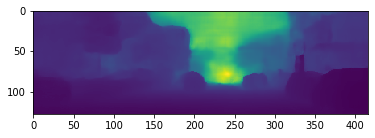

In [0]:
plt.imshow(output[0,:,:,0])

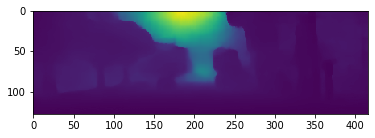

In [0]:
plt.imshow(output[40,:,:,0])

In [0]:
image_files = list()
image_files.append('./depth_from_video_in_the_wild/data_example/erfurt_93/0000000002.png')


In [0]:
new_output = output[0][:,:,0:(416*2),:]
new_output = np.concatenate((new_output,new_output,new_output,new_output),axis=0)
print(new_output.shape)

IndexError: ignored